[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cpeng2/h1b_data/blob/main/Project_3_Peng_v2.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Step 1: Load and split the data

In [2]:
# load the file
url = "https://www.dropbox.com/scl/fi/ezo4vc5jfgwsd4o5ytrzz/LCA_Disclosure_Data_FY2025_Q3.csv?rlkey=kn6ewdyacyoh4nlz1r4jegxm0&dl=1"
h1b = pd.read_csv(url, low_memory=False)
print(h1b.head())

          CASE_NUMBER CASE_STATUS RECEIVED_DATE DECISION_DATE  \
0  I-200-25181-143446   Withdrawn       6/30/25       6/30/25   
1  I-200-25181-141251   Withdrawn       6/30/25       6/30/25   
2  I-200-25181-142198   Withdrawn       6/30/25       6/30/25   
3  I-200-25181-138847   Withdrawn       6/30/25       6/30/25   
4  I-200-25181-140402   Withdrawn       6/30/25       6/30/25   

  ORIGINAL_CERT_DATE VISA_CLASS                              JOB_TITLE  \
0                NaN       H-1B                        Data Scientists   
1                NaN       H-1B  IT Technical Associate - Developer II   
2                NaN       H-1B                     Research Associate   
3                NaN       H-1B          Business Architecture Manager   
4                NaN       H-1B                         Senior Manager   

  SOC_CODE                                  SOC_TITLE FULL_TIME_POSITION  ...  \
0  15-2051                            Data Scientists                  Y  ...   
1 

In [3]:
# Select features and drop NA
fea_col = ["CASE_STATUS", "VISA_CLASS", "SOC_CODE", "SOC_TITLE", "FULL_TIME_POSITION",
                   "EMPLOYER_CITY", "PREVAILING_WAGE", "EMPLOYER_NAME"]

h1b[fea_col].head(10)
h1b_no_missing = h1b[fea_col].dropna()
print(h1b_no_missing.shape)

(479005, 8)


In [4]:
# Split the data and use "stratify" to balance the data
X = h1b_no_missing[fea_col].drop("CASE_STATUS", axis=1)
y = h1b_no_missing["CASE_STATUS"]
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape

CASE_STATUS
Certified                446456
Certified - Withdrawn     22002
Withdrawn                  7667
Denied                     2880
Name: count, dtype: int64


((383204, 7), (95801, 7))

In [5]:
# Identify categorical and numerical variables (columns)
cat_cols = ["VISA_CLASS", "SOC_CODE", "FULL_TIME_POSITION",
                   "EMPLOYER_CITY", "EMPLOYER_NAME"]
num_cols = ["PREVAILING_WAGE"]

In [6]:
# extra the first 2 digits of SOC_CODE
X_train["SOC_CODE"] = X_train["SOC_CODE"].str.extract(r"(\d{2})", expand=False)
print(X_train["SOC_CODE"].value_counts().head(20))
X_train.head()

SOC_CODE
15    231787
17     38357
13     34023
11     21405
19     16140
29     16050
25     14138
27      4065
23      2469
41      2141
21      1833
43       194
53       186
49        88
35        86
45        67
31        62
51        47
39        30
47        15
Name: count, dtype: int64


,VISA_CLASS,SOC_CODE,SOC_TITLE,FULL_TIME_POSITION,EMPLOYER_CITY,PREVAILING_WAGE,EMPLOYER_NAME
121861,H-1B,15,Information Technology Project Managers,Y,EAST BRUNSWICK,"$62,338.00",WIPRO LIMITED
431833,H-1B,15,Software Developers,Y,Mountain View,"$137,259.00",Google LLC
381671,H-1B,15,Software Developers,Y,Minneapolis,"$141,751.00",U.S. Bank National Association
361413,H-1B,13,Management Analysts,Y,Washington,"$122,970.00",Japan International Transport and Tourism Inst...
289090,H-1B,15,Computer Programmers,Y,EAST BRUNSWICK,"$78,998.00",WIPRO LIMITED


In [7]:
# pipeline for numerical data
def extra_numbers(X):
    X = X.copy()
    X = X.replace('[$,]', '', regex=True)
    return pd.to_numeric(X.squeeze(), errors='coerce').to_frame()

num_pipeline = Pipeline([
    ("clean", FunctionTransformer(extra_numbers, validate=False)),
    ("scale", MaxAbsScaler())
])

In [8]:
# Combined the categorical and numerical data pipeline
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(sparse_output=True, handle_unknown="ignore"), cat_cols),
    ("num", num_pipeline, num_cols)
    ],
    # output as sparse to be memeory efficient
    sparse_threshold=1.0)

# fit the preprocessor and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print(X_train_processed.shape)
print(X_test_processed.shape)

(383204, 65268)
(95801, 65268)


Step 2: PCA for feature selection

In [9]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report
from xgboost import XGBClassifier
import numpy as np


Since PCA does not support sparse data, I utilized Truncated SVD (as suggested on DataCamp). Due to computational constraints, which caused crashes when attempting to capture 95% of the variance, I pragmatically set n_components = 2600, which captures approximately 83% variance.

In [ ]:
#Reduce dimensionality by TruncatedSVD

#Stratified sampling (20%)
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train_processed,
    y_train,
    test_size=0.8,
    stratify=y_train,
    random_state=42
)
#convert data to float32 for better memory usage
X_train_32 = X_train_sub.astype("float32")
X_test_32 = X_test_processed.astype("float32")

#fit with many components
svd = TruncatedSVD(n_components=2600)
X_train_svd = svd.fit_transform(X_train_32)
X_test_svd = svd.transform(X_test_32)

print(np.cumsum(svd.explained_variance_ratio_))


[0.02313503 0.11375922 0.15041146 ... 0.8365127  0.83653855 0.8365644 ]


My best performing model was XGBoost, so I tested out reduced data on this model. It deos not improve perforamce of the model. The accuracy rate is about the same but the precision rate on "Denied" and "Withdrawn" decreased.

In [11]:
# Encode target variable for XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_sub)
y_test_encoded = le.transform(y_test)

# Train an XGBoost model
xgb = XGBClassifier()
xgb.fit(X_train_svd, y_train_encoded)
y_pred_encoded = xgb.predict(X_test_svd)
acc = xgb.score(X_test_svd, y_test_encoded)

# Decode predictions for classification report
y_pred = le.inverse_transform(y_pred_encoded)

# Evaluate
print("Prediction Accuracy: {:.2f}".format(acc))
print(classification_report(y_test, y_pred))

Prediction Accuracy: 0.93


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                       precision    recall  f1-score   support

            Certified       0.93      1.00      0.96     89291
Certified - Withdrawn       0.46      0.00      0.00      4400
               Denied       0.00      0.00      0.00       576
            Withdrawn       0.00      0.00      0.00      1534

             accuracy                           0.93     95801
            macro avg       0.35      0.25      0.24     95801
         weighted avg       0.89      0.93      0.90     95801



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Step 3: Apply 3-types of clustering on the data and visualize the output

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

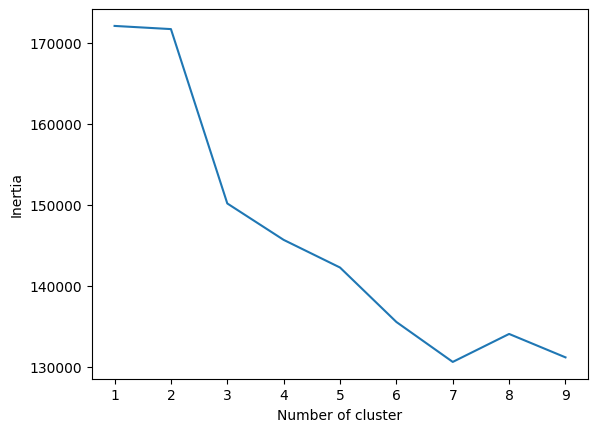

In [13]:
# Elbow method to find the optimal number of clusters
inertiaVals = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000, random_state=42).fit(X_train_svd)
    inertiaVals[k] = kmeansTmp.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

Notes: 1. The best number of cluster is hard to determine. The results are different each time. I use K=6 for the following tasks. 2. Since I'm working with high-dimentional sparse data, the best way to visualize it is to use TruncatedSVD. PCA doesn't work with sparse data. 

ARI: 0.00
Silhouette Score: 0.06


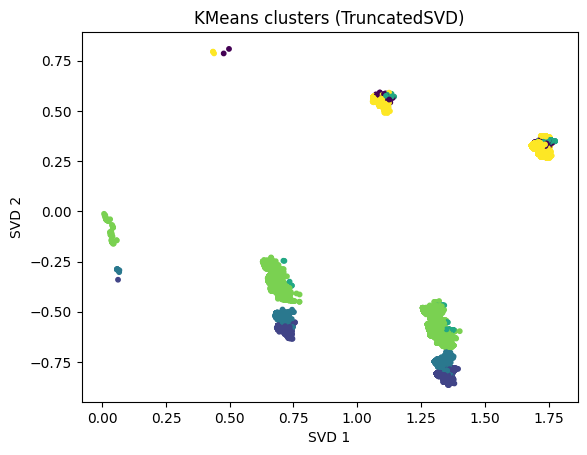

In [14]:
# visualize the clusters without reduced dimensionality
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X_train_sub)
ari = adjusted_rand_score(y_train_sub, labels)
sil = silhouette_score(X_train_sub, kmeans.labels_)
print("ARI: {:.2f}".format(ari))
print("Silhouette Score: {:.2f}".format(sil))   

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_train_sub)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans.labels_, s=10)
plt.xlabel("SVD 1")
plt.ylabel("SVD 2")
plt.title("KMeans clusters (TruncatedSVD)")
plt.show()

ARI: 0.02
Silhouette Score: 0.09


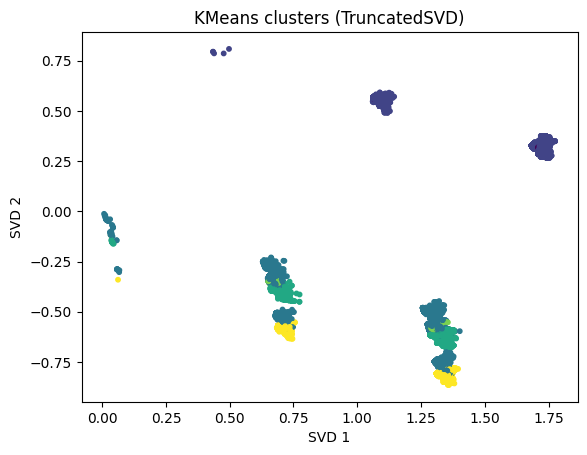

: 

In [ ]:
# visualize the clusters with reduced dimensionality
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X_train_svd)
ari = adjusted_rand_score(y_train_sub, labels)
sil = silhouette_score(X_train_svd, kmeans.labels_)
print("ARI: {:.2f}".format(ari))
print("Silhouette Score: {:.2f}".format(sil))

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_train_svd)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans.labels_, s=10)
plt.xlabel("SVD 1")
plt.ylabel("SVD 2")
plt.title("KMeans clusters (TruncatedSVD)")
plt.show()


After stratified sampling, the DBSCAN is now able to run, but Agglomerative clusting still crushes the kernal.

In [ ]:
#Agglomerative clustering without reduced dimensionality
#Reduce dimensionality (to prevent memory issues)
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_train_sub)

#Fit agglomerative clustering
agg = AgglomerativeClustering(n_clusters=6, metric="euclidean", linkage="average")
labels = agg.fit_predict(X_reduced)

ari = adjusted_rand_score(y_train_sub, labels)
print("ARI: {:.2f}".format(ari))
#sil = silhouette_score(X_reduced, labels)
#print("Silhouette Score: {:.2f}".format(sil))

# Reduce further for plotting
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_train_sub)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=10)
plt.xlabel("SVD 1")
plt.ylabel("SVD 2")
plt.title("Agglomerative Clustering (TruncatedSVD)")
plt.show()

In [ ]:
#Aggolmerate clustering with reduced dimensionality
#Reduce dimensionality
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_train_svd)

#Fit agglomerative clustering
agg = AgglomerativeClustering(n_clusters=6, metric="euclidean", linkage="average")
labels = agg.fit_predict(X_reduced)

ari = adjusted_rand_score(y_train_sub, labels)
print("ARI: {:.2f}".format(ari))
#sil = silhouette_score(X_reduced, labels)
#print("Silhouette Score: {:.2f}".format(sil))   

#Further reduce for plotting (optional)
svd2 = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd2.fit_transform(X_train_svd)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=10)
plt.show()


: 

ARI: 0.00


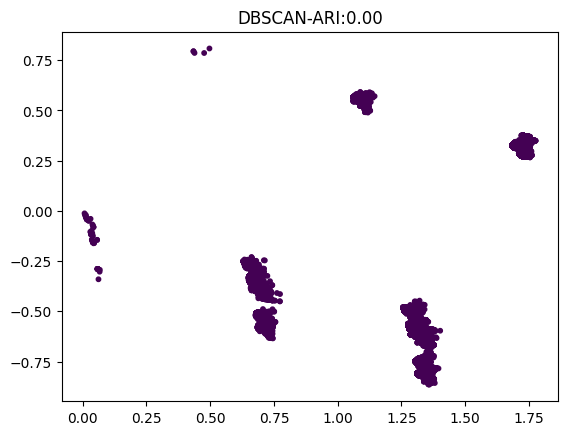

In [ ]:
#BDSCAN without reduced dimensionality
svd = TruncatedSVD(n_components=50, random_state=42) # Reduce dimensionality (to prevent memory issues but didn't work)
X_reduced = svd.fit_transform(X_train_sub) 

dbscan = DBSCAN(metric="cosine", eps=0.3, min_samples=10)
labels = dbscan.fit_predict(X_reduced)

ari = adjusted_rand_score(y_train_sub, labels)
print("ARI: {:.2f}".format(ari))

#sil = silhouette_score(X_reduced, labels, metric="cosine")
#print("Silhouette Score: {:.2f}".format(sil))

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_train_sub)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=dbscan.labels_, s=10)
plt.title("DBSCAN-ARI:{:.2f}".format(ari))
plt.show()

ARI: 0.00


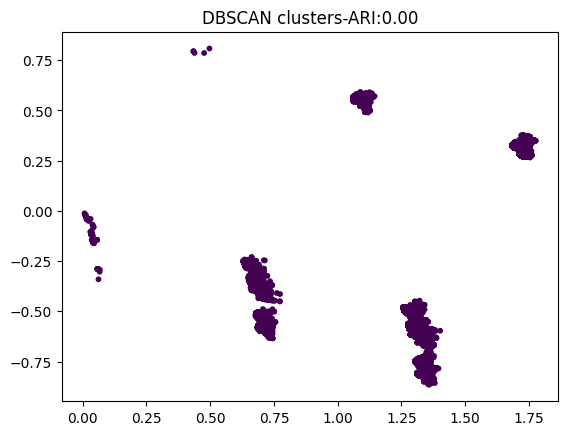

In [ ]:
#DBSCAN with reduced dimensionality
svd = TruncatedSVD(n_components=50, random_state=42) # Reduce dimensionality (to prevent memory issues but didn't work)
X_reduced = svd.fit_transform(X_train_svd)

dbscan = DBSCAN(metric="cosine", eps=0.3, min_samples=10)
labels = dbscan.fit_predict(X_reduced)

ari = adjusted_rand_score(y_train_sub, labels)
print("ARI: {:.2f}".format(ari))

#sil = silhouette_score(X_reduced, labels, metric="cosine")
#print("Silhouette Score: {:.2f}".format(sil))

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_train_svd)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=dbscan.labels_, s=10)
plt.title("DBSCAN-ARI:{:.2f}".format(ari))
plt.show()


Summary: When experimenting with XGBoost, Dimentionality reduction doesn't really imporve the perforamce of the model. I assume it is due to the high dimentional sparse data that I'm working with. With this type of data, Kmeans is the best model for clusting, but plotting out the data also doesn't really tell much about the distribution or nature of the data. After stratified sampling, the DBSCAN models were able to run, but Agglomerative clustering still crashed the kernel.